# Predict if The Disaster Tweet is Real or Not

- [Kaggle competition dataset](https://www.kaggle.com/competitions/nlp-getting-started/data)

In [1]:
from os import path
import pandas as pd

DATASET_FOLDER = "../data/nlp-getting-started"
TRAIN_FILE = path.join(DATASET_FOLDER, "train.csv") 

## 1. First look at the data

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: xlabel='target'>

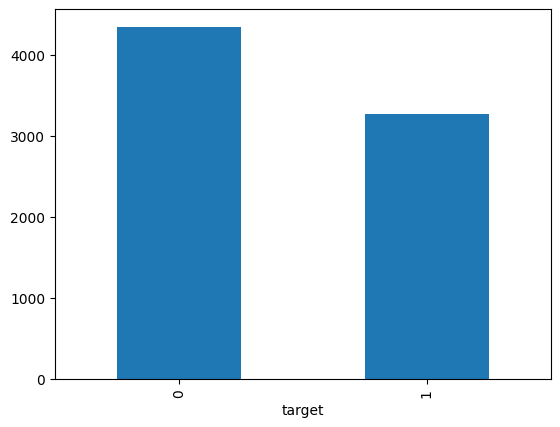

In [2]:
df_tweets = pd.read_csv(TRAIN_FILE)

display(df_tweets.describe())
display(df_tweets.head())
# barplot of the target variable
df_tweets.target.value_counts().plot(kind="bar")

## 2. Data cleaning

In [3]:
# Fill NaN values
df_tweets.keyword.fillna("", inplace=True)
df_tweets.location.fillna("", inplace=True)

print(df_tweets.head())

   id keyword location                                               text  \
0   1                   Our Deeds are the Reason of this #earthquake M...   
1   4                              Forest fire near La Ronge Sask. Canada   
2   5                   All residents asked to 'shelter in place' are ...   
3   6                   13,000 people receive #wildfires evacuation or...   
4   7                   Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [4]:
# Transform location into a numeric variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_tweets["location"] = le.fit_transform(df_tweets["location"])

print(df_tweets.head())

   id keyword  location                                               text  \
0   1                 0  Our Deeds are the Reason of this #earthquake M...   
1   4                 0             Forest fire near La Ronge Sask. Canada   
2   5                 0  All residents asked to 'shelter in place' are ...   
3   6                 0  13,000 people receive #wildfires evacuation or...   
4   7                 0  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [5]:
# apply one-hot encoding to the keyword variable
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(df_tweets[["keyword"]])
keyword_ohe = ohe.transform(df_tweets[["keyword"]]).toarray()
df_keyword = pd.DataFrame(keyword_ohe, columns=ohe.categories_[0])
df_tweets = pd.concat([df_tweets, df_keyword], axis=1)
df_tweets.drop(columns=["keyword"], inplace=True)

print(df_tweets.head())

   id  location                                               text  target  \
0   1         0  Our Deeds are the Reason of this #earthquake M...       1   
1   4         0             Forest fire near La Ronge Sask. Canada       1   
2   5         0  All residents asked to 'shelter in place' are ...       1   
3   6         0  13,000 people receive #wildfires evacuation or...       1   
4   7         0  Just got sent this photo from Ruby #Alaska as ...       1   

        ablaze  accident  aftershock  airplane%20accident  ambulance  ...  \
0  1.0     0.0       0.0         0.0                  0.0        0.0  ...   
1  1.0     0.0       0.0         0.0                  0.0        0.0  ...   
2  1.0     0.0       0.0         0.0                  0.0        0.0  ...   
3  1.0     0.0       0.0         0.0                  0.0        0.0  ...   
4  1.0     0.0       0.0         0.0                  0.0        0.0  ...   

   weapons  whirlwind  wild%20fires  wildfire  windstorm  wounded  w

## 2. Metodology

1. Create TF-IDF matrix
2. Plot covariance matrix
3. Select features with highest covariance
4. Apply LDA using selected features
5. Applying PCA turns out to be better

In [6]:
# create TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
# remove numbers
vectorizer = TfidfVectorizer(stop_words=stop_words, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', max_features=1000)
X = vectorizer.fit_transform(df_tweets.text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guilhermeleonardonunes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# get correlation matrix with target variable and select the most correlated features
# create a dataframe with the features and the target variable
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_features["target"] = df_tweets.target
# add keyword and location columns
df_features["location"] = df_tweets.location
# add one-hot encoded keyword columns
df_features = pd.concat([df_features, df_keyword], axis=1)
# get correlation matrix
corr_matrix = df_features.corr()
# get the most correlated features
corr_target = abs(corr_matrix["target"])
relevant_features = corr_target[corr_target > 0.05]
# drop the target variable
relevant_features = relevant_features.drop("target")
display(relevant_features)
# count relevant features
print("Number of relevant features: {}".format(len(relevant_features)))

16yr            0.068862
70th            0.052469
abc             0.067074
accident        0.063369
affected        0.069293
                  ...   
typhoon         0.077838
wild%20fires    0.057003
wildfire        0.059864
wreckage        0.082675
wrecked         0.051132
Name: target, Length: 185, dtype: float64

Number of relevant features: 185


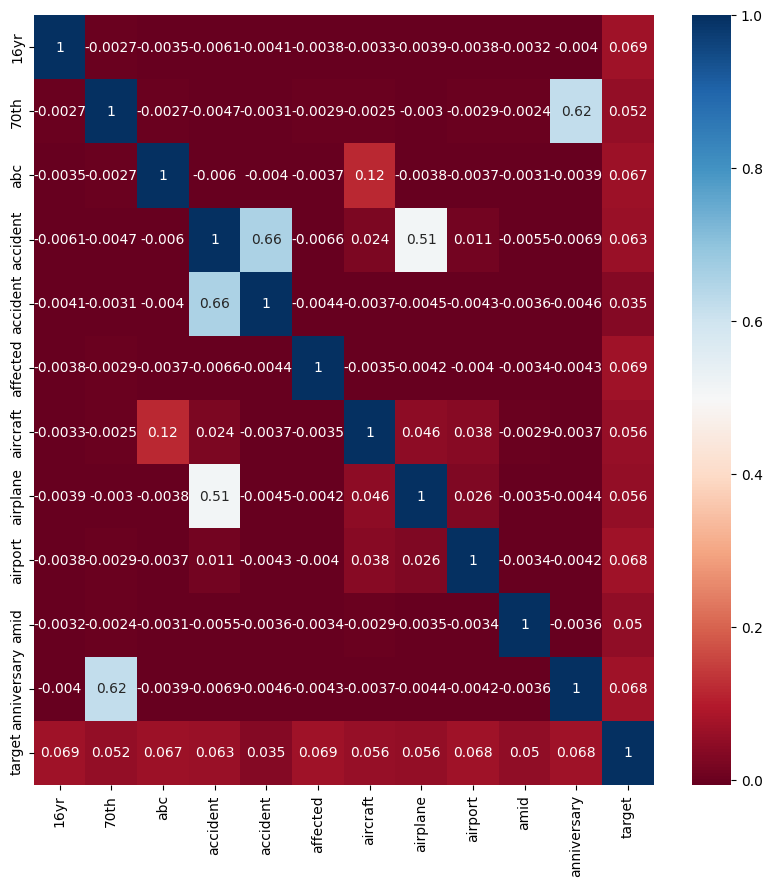

In [8]:
# plot correlation matrix of relevant features with target variable
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# make data frame with top 10 most correlated features plus target variable
df_top10 = df_features[relevant_features.index[:10]].copy()
df_top10["target"] = df_features["target"]

# plot only the 10 first relavant of highest correlation with target variable
sns.heatmap(df_top10.corr(), annot=True, cmap="RdBu")
plt.show()


In [9]:
print(df_features.head())

   16yr  70th  aba  abc  ablaze  accident  across  act  action  actually  ...  \
0   0.0   0.0  0.0  0.0     0.0       0.0     0.0  0.0     0.0       0.0  ...   
1   0.0   0.0  0.0  0.0     0.0       0.0     0.0  0.0     0.0       0.0  ...   
2   0.0   0.0  0.0  0.0     0.0       0.0     0.0  0.0     0.0       0.0  ...   
3   0.0   0.0  0.0  0.0     0.0       0.0     0.0  0.0     0.0       0.0  ...   
4   0.0   0.0  0.0  0.0     0.0       0.0     0.0  0.0     0.0       0.0  ...   

   weapons  whirlwind  wild%20fires  wildfire  windstorm  wounded  wounds  \
0      0.0        0.0           0.0       0.0        0.0      0.0     0.0   
1      0.0        0.0           0.0       0.0        0.0      0.0     0.0   
2      0.0        0.0           0.0       0.0        0.0      0.0     0.0   
3      0.0        0.0           0.0       0.0        0.0      0.0     0.0   
4      0.0        0.0           0.0       0.0        0.0      0.0     0.0   

   wreck  wreckage  wrecked  
0    0.0       0.0  

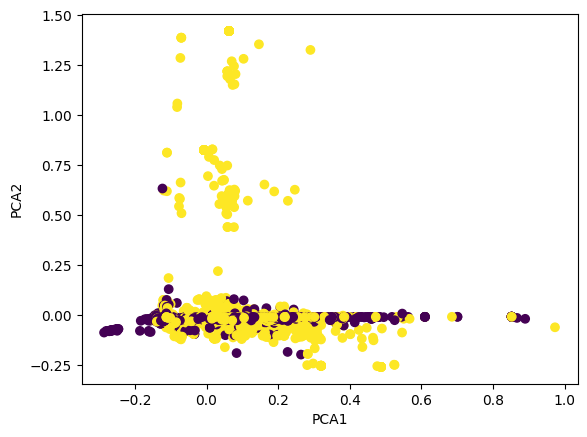

In [10]:
# apply PCA to most correlated features
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(df_features[relevant_features.index])

# plot PCA
import matplotlib.pyplot as plt
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_features.target)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

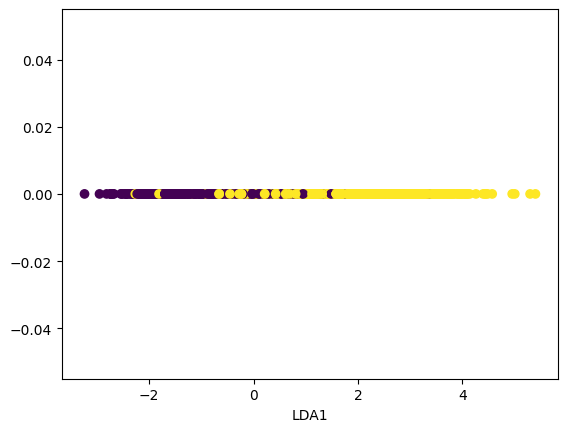

In [11]:
# apply LDA to most correlated features
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(df_features[relevant_features.index], df_features.target)

# plot LDA
import matplotlib.pyplot as plt
plt.scatter(X_lda, [0]*len(X_lda), c=df_features.target)
plt.xlabel("LDA1")
plt.show()


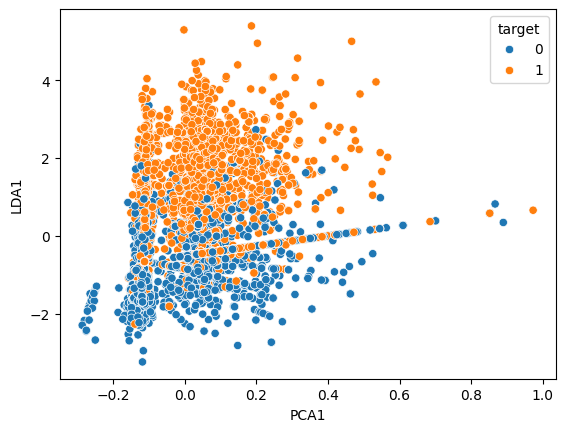

In [12]:
# create a dataframe with PCA 1 and LDA 1
# get all pcas

df_pca_lda = pd.DataFrame()
df_pca_lda["PCA1"] = X_pca[:,0]
df_pca_lda["PCA2"] = X_pca[:,1]
df_pca_lda["PCA3"] = X_pca[:,2]
df_pca_lda["PCA4"] = X_pca[:,3]
df_pca_lda["PCA5"] = X_pca[:,4]
df_pca_lda["LDA1"] = X_lda
df_pca_lda["target"] = df_features.target

# plot PCA and LDA
import seaborn as sns
sns.scatterplot(data=df_pca_lda, x="PCA1", y="LDA1", hue="target")
plt.show()


In [13]:
X.shape

(7613, 1000)

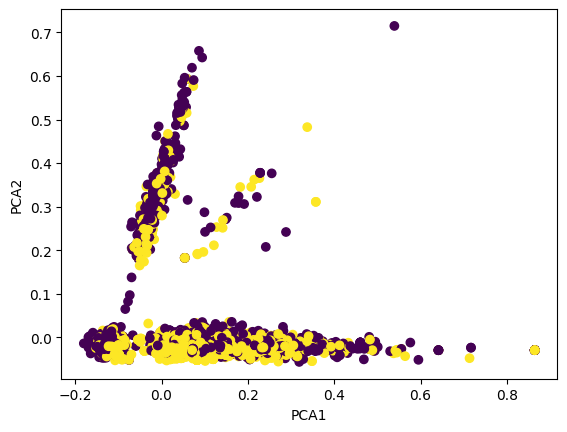

In [14]:
# apply PCA to reduce the dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
X_pca = pca.fit_transform(X.toarray())

# plot the PCA components
import matplotlib.pyplot as plt
# print all by all principal components

# print 
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_tweets.target)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()


In [15]:
# create a dataframe to store the results of the different models
results = []


In [16]:
# train a svm classifier with X and validate by applying all metrics below
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df_tweets.target, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# get the accuracy score

from sklearn.metrics import recall_score, precision_score
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
# f1 score
from sklearn.metrics import f1_score
print("F1 score: {}".format(f1_score(y_test, y_pred)))
# accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

# add results to results dataframe
results.append({"model": "Sem Aplicação de PCA - Sem seleção de features", "accuracy": accuracy_score(y_test, y_pred), "precision": precision_score(y_test, y_pred), "recall": recall_score(y_test, y_pred), "f1": f1_score(y_test, y_pred)})


Recall: 0.6718027734976888
Precision: 0.7970749542961609
F1 score: 0.7290969899665554
Accuracy: 0.7872619829284307


In [17]:
# train a svm classifier with X using most relevant features and validate by applying all metrics below
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features[relevant_features.index], df_features.target, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# get the accuracy score

from sklearn.metrics import recall_score, precision_score
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
# f1 score
from sklearn.metrics import f1_score
print("F1 score: {}".format(f1_score(y_test, y_pred)))
# accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

# add results to results dataframe
results.append({"model": "Sem Aplicação de PCA - Com seleção de features", "accuracy": accuracy_score(y_test, y_pred), "precision": precision_score(y_test, y_pred), "recall": recall_score(y_test, y_pred), "f1": f1_score(y_test, y_pred)})

Recall: 0.5932203389830508
Precision: 0.8071278825995807
F1 score: 0.6838365896980462
Accuracy: 0.7662508207485227


In [18]:
# apply pca on features_df and train a svm classifier with X and validate by applying all metrics below
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# apply PCA to reduce the dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=186)
X_pca_selected = pca.fit_transform(df_features[relevant_features.index])

X_train, X_test, y_train, y_test = train_test_split(X_pca_selected, df_features.target, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# get the accuracy score

from sklearn.metrics import recall_score, precision_score
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
# f1 score
from sklearn.metrics import f1_score
print("F1 score: {}".format(f1_score(y_test, y_pred)))
# accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

# add results to results list
results.append({"model": "Com Aplicação de PCA - Com seleção de features", "accuracy": accuracy_score(y_test, y_pred), "precision": precision_score(y_test, y_pred), "recall": recall_score(y_test, y_pred), "f1": f1_score(y_test, y_pred)})


Recall: 0.5932203389830508
Precision: 0.8071278825995807
F1 score: 0.6838365896980462
Accuracy: 0.7662508207485227


In [19]:
# train a svm classifier with PCA features and validate by applying revocall and precision
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_pca, df_tweets.target, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

from sklearn.metrics import recall_score, precision_score
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
# f1 score
from sklearn.metrics import f1_score
print("F1 score: {}".format(f1_score(y_test, y_pred)))
# accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

# add results to results list
results.append({"model": "Com Aplicação de PCA - Sem seleção de features", "accuracy": accuracy_score(y_test, y_pred), "precision": precision_score(y_test, y_pred), "recall": recall_score(y_test, y_pred), "f1": f1_score(y_test, y_pred)})

Recall: 0.6718027734976888
Precision: 0.7956204379562044
F1 score: 0.7284878863826232
Accuracy: 0.7866053841103086


In [20]:
# create a dataframe with the results
df_results = pd.DataFrame(results)
display(df_results)

# create a printable version of the results
df_results_print = df_results.copy()
df_results_print["accuracy"] = df_results_print["accuracy"].apply(lambda x: "{:.2f}".format(x))
df_results_print["precision"] = df_results_print["precision"].apply(lambda x: "{:.2f}".format(x))
df_results_print["recall"] = df_results_print["recall"].apply(lambda x: "{:.2f}".format(x))
df_results_print["f1"] = df_results_print["f1"].apply(lambda x: "{:.2f}".format(x))
display(df_results_print)


,model,accuracy,precision,recall,f1
0,Sem Aplicação de PCA - Sem seleção de features,0.787262,0.797075,0.671803,0.729097
1,Sem Aplicação de PCA - Com seleção de features,0.766251,0.807128,0.593220,0.683837
2,Com Aplicação de PCA - Com seleção de features,0.766251,0.807128,0.593220,0.683837
3,Com Aplicação de PCA - Sem seleção de features,0.786605,0.795620,0.671803,0.728488


,model,accuracy,precision,recall,f1
0,Sem Aplicação de PCA - Sem seleção de features,0.79,0.80,0.67,0.73
1,Sem Aplicação de PCA - Com seleção de features,0.77,0.81,0.59,0.68
2,Com Aplicação de PCA - Com seleção de features,0.77,0.81,0.59,0.68
3,Com Aplicação de PCA - Sem seleção de features,0.79,0.80,0.67,0.73


In [21]:
# train a svm classifier only applying lda features and validate by applying revocall and precision
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X_lda, df_features.target, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

from sklearn.metrics import recall_score, precision_score
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
# f1 score
from sklearn.metrics import f1_score
print("F1 score: {}".format(f1_score(y_test, y_pred)))
# accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))


Recall: 0.5778120184899846
Precision: 0.8205689277899344
F1 score: 0.678119349005425
Accuracy: 0.7662508207485227


In [22]:
# train a svm classifier with pca lda dataframe and validate by applying same metrics as above
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

target = df_pca_lda.pop("target")

X_train, X_test, y_train, y_test = train_test_split(df_pca_lda, target, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

from sklearn.metrics import recall_score, precision_score
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
# f1 score
from sklearn.metrics import f1_score
print("F1 score: {}".format(f1_score(y_test, y_pred)))
# accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))


Recall: 0.5993836671802774
Precision: 0.8138075313807531
F1 score: 0.6903283052351374
Accuracy: 0.7708470124753776


In [23]:
# train a svm classifier with only pca features and validate by applying same metrics as above
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

target = df_pca_lda.pop("target")

X_train, X_test, y_train, y_test = train_test_split(df_pca_lda, target, test_size=0.2, random_state=42)

svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

from sklearn.metrics import recall_score, precision_score
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
# f1 score
from sklearn.metrics import f1_score
print("F1 score: {}".format(f1_score(y_test, y_pred)))
# accuracy
from sklearn.metrics import accuracy_score
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))


KeyError: 'target'

In [ ]:
## Apply the same to the test dataset
TEST_FILE = path.join(DATASET_FOLDER, "test.csv")

df_test = pd.read_csv(TEST_FILE)
df_test.keyword.fillna("", inplace=True)
df_test.location.fillna("", inplace=True)
# use vectorizer from train dataset

df_test["location"] = le.transform(df_test["location"])

keyword_ohe = ohe.transform(df_test[["keyword"]]).toarray()
df_keyword = pd.DataFrame(keyword_ohe, columns=ohe.categories_[0])
df_test = pd.concat([df_test, df_keyword], axis=1)
df_test.drop(columns=["keyword"], inplace=True)
X_test = vectorizer.transform(df_test.text)
# apply learned lda to test dataset
X_lda_test = lda.transform(df_test[relevant_features.index])

y_pred = svm.predict(X_lda_test)
df_submission = pd.DataFrame()
df_submission["id"] = df_test.id
df_submission["target"] = y_pred
df_submission.to_csv("submission.csv", index=False)



In [ ]:
# apply linear discriminant analysis to reduce the dimensionality
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
n_components = min(X.shape[1], len(df_tweets.target.unique()) - 1)
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X.toarray(), df_tweets.target)

# plot the LDA components
# import matplotlib.pyplot as plt
# plt.scatter(X_lda, [0]*len(X_lda), c=df_tweets.target)
# plt.xlabel("LDA component 1")
# plt.show()

# plot LDA and target variable
import seaborn as sns
df_lda = pd.DataFrame(X_lda, columns=["LDA1"])
df_lda["target"] = df_tweets.target
sns.scatterplot(data=df_lda, x="LDA1", y="target", hue="target")
plt.show()



## 2.1 Apply PCA + MLDA to the data

### 2.1.1 Calculate mean vector of most relavant features

In [ ]:
X_most_relevant = df_features[relevant_features.index]

# transform to np array
X_most_relevant = X_most_relevant.to_numpy()

print(X_most_relevant.shape)

In [ ]:
# calculate average vector
average_vector = X_most_relevant.mean(axis=0)
print("Average vector shape: {}".format(average_vector.shape))

### 2.1.2 Subtract mean vector from each twit

In [ ]:
zero_mean_tweets_array = X_most_relevant - average_vector
print("Zero mean tweets array shape: {}".format(zero_mean_tweets_array.shape))

### 2.1.3 Apply PCA to zero-meaned data

In [ ]:
# apply PCA to zero mean tweets array
pca = PCA(n_components=2)
pca.fit(zero_mean_tweets_array)


### 2.1.4 Multiply PCA matrix by zero-meaned data

In [ ]:
# multiply pca matrix
import numpy as np
 
pca_tweets_array = np.dot(zero_mean_tweets_array, pca.components_.T)
print(pca_tweets_array.shape)

In [ ]:
# plot PCA images array
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(pca_tweets_array[:, 0], pca_tweets_array[:, 1], c=df_tweets.target)
plt.show()


### 2.1.5 Apply MLDA to PCA-transformed data

In [ ]:
# apply LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(pca_tweets_array, df_tweets.target)

# multiply lda matrix
lda_images_array = lda.transform(pca_tweets_array)
print(lda_images_array.shape)

# plot LDA images array
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(lda_images_array[:, 0], [0]*len(lda_images_array), c=df_tweets.target)
plt.show()



## 3. Testing

In [ ]:
# read test data
TEST_FILE = path.join(DATASET_FOLDER, "test.csv")
df_test = pd.read_csv(TEST_FILE)
# add target column to test data
display(df_test.describe())
display(df_test.head())
# count
print("Number of tweets: {}".format(len(df_test)))

In [ ]:
# create TF-IDF features
X_test = vectorizer.transform(df_test.text)

columns_names = vectorizer.get_feature_names_out()
df_test_features = pd.DataFrame(X_test.toarray(), columns=columns_names)

# apply PCA to most correlated features
X_test_pca = pca.transform(df_test_features[relevant_features.index])
